In [81]:
import csv
import os

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import random_split
from torchvision import datasets, transforms
from PIL.Image import NEAREST


In [82]:
CURR_DIR = os.path.dirname(os.path.realpath('./p3'))
DATA_DIR = os.path.join(CURR_DIR, 'data')
TRAINSET_DIR = os.path.join(DATA_DIR, 'trainset/trainset')
TESTSET_DIR = os.path.join(DATA_DIR, 'testset')
MODEL_DIR = CURR_DIR
# comment below line if running locally
MODEL_DIR = "/rap/jvb-000-aa/COURS2019/etudiants/user20"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_PATH = os.path.join(MODEL_DIR, 'model.pt')

In [110]:
def get_dataset(transform=True):
    # define some transformations
    data_transform = transforms.Compose([
        transforms.RandomRotation(30, resample=PIL.Image.NEAREST),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # define the whole training dataset
    if transform is False:
        data_transform = transforms.Compose([
            transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = datasets.ImageFolder(root=TRAINSET_DIR,
                                   transform=data_transform)

    print("Dataset length: {}".format(len(dataset)))
    return dataset

In [111]:
dataset = get_dataset()

Dataset length: 19998


In [112]:
def get_dataloader(dataset, valid_dataset):
    # not using complicated sampling yet
    # can be improved though
    split_percentage = 0.02

    # use StratifiedShuffle and get the indices
    total_len = len(dataset)
    fake_X = np.zeros(total_len)
    fake_y = [x[1] for x in dataset.samples]

    ss = StratifiedShuffleSplit(
        n_splits=1, test_size=split_percentage, random_state=0)
    train_indices, validation_indices = list(ss.split(fake_X, fake_y))[0]

    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    validation_sampler = torch.utils.data.SubsetRandomSampler(
        validation_indices)
    train_dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=20, shuffle=False,
        sampler=train_sampler, num_workers=4)
    validation_dataloader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=20, shuffle=False,
        sampler=validation_sampler, num_workers=4)

    return train_dataloader, validation_dataloader

In [113]:
# create dataset
dataset = get_dataset()
valid_dataset = get_dataset(False)
# create dataloader
train_dataloader, validation_dataloader = get_dataloader(dataset, valid_dataset)

Dataset length: 19998
Dataset length: 19998


In [16]:
# c1 = 0
# c2 = 0
for _, (x, y) in enumerate(validation_dataloader):
    m =x.max()
    mi = x.min()
    print(m, mi)
#     z = y == 1
#     c1 += len(y[z])
#     z = y == 0
#     c2 += len(y[z])
# print(c1, c2)

tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) 

tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) 

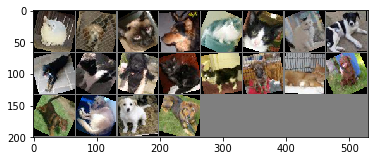

  Cat   Dog   Cat   Dog


In [116]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

classes = {0: 'Cat', 1: "Dog"}
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j].item()] for j in range(4)))

In [79]:
class LittleClassifier(nn.Module):
    def __init__(self):
        super(LittleClassifier, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=3
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=3
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32, out_channels=32, kernel_size=3
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=3
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=3
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),

#             nn.Conv2d(
#                 in_channels=64, out_channels=128, kernel_size=3, padding=1
#             ),
#             nn.ReLU(),
#             nn.Conv2d(
#                 in_channels=128, out_channels=128, kernel_size=3, padding=1
#             ),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=(2, 2)),

#             nn.Conv2d(
#                 in_channels=128, out_channels=256, kernel_size=3, padding=1
#             ),
#             nn.ReLU(),
#             nn.Conv2d(
#                 in_channels=256, out_channels=256, kernel_size=3, padding=1
#             ),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=(2, 2)),

#             nn.Conv2d(
#                 in_channels=256, out_channels=512, kernel_size=3, padding=1
#             ),
#             nn.ReLU(),
#             nn.Conv2d(
#                 in_channels=512, out_channels=512, kernel_size=3, padding=1
#             ),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=(2, 2)),

        )
        self.lin = nn.Sequential(
            nn.Linear(4*4*64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
#         print(x.shape)
        x = x.view(-1, 4*4*64)
#         print(x.shape)
        x = self.lin(x)
#         print(x.shape)
        return x

In [119]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5,padding=1, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5,padding=1, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5,padding=1, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [120]:
model = Net()
model = model.to(DEVICE)

In [121]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()

In [122]:
epochs = 50

In [123]:
for epoch in range(epochs):
    losses = []

    # Train
    model.train()
    total = 0
    correct = 0
    for i,(inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
#         print(outputs.shape)
#         print(targets.shape)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        with torch.no_grad():
            p = torch.argmax(outputs, 1)
            correct += p.eq(targets).sum()
            total += targets.size(0)
        
    print('Epoch : %d Loss : %f Train Acc: %f' % (epoch, np.mean(losses), 100*correct/total))

    # Evaluate
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for _, (inputs, targets) in enumerate(validation_dataloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            predicted = model(inputs)
#             print(predicted)
            predicted = torch.argmax(predicted, 1)
#             print(predicted)
#             print(targets)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

    print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
    print('--------------------------------------------------------------')

Epoch : 0 Loss : 0.679416 Train Acc: 56.000000
Epoch : 0 Test Acc : 60.000
--------------------------------------------------------------
Epoch : 1 Loss : 0.629436 Train Acc: 64.000000
Epoch : 1 Test Acc : 65.000
--------------------------------------------------------------
Epoch : 2 Loss : 0.583577 Train Acc: 69.000000
Epoch : 2 Test Acc : 68.000
--------------------------------------------------------------
Epoch : 3 Loss : 0.550058 Train Acc: 72.000000
Epoch : 3 Test Acc : 71.000
--------------------------------------------------------------
Epoch : 4 Loss : 0.516652 Train Acc: 74.000000
Epoch : 4 Test Acc : 71.000
--------------------------------------------------------------
Epoch : 5 Loss : 0.497862 Train Acc: 75.000000
Epoch : 5 Test Acc : 77.000
--------------------------------------------------------------
Epoch : 6 Loss : 0.478439 Train Acc: 77.000000
Epoch : 6 Test Acc : 77.000
--------------------------------------------------------------
Epoch : 7 Loss : 0.461309 Train Ac

In [54]:
# Evaluate
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for _, (inputs, targets) in enumerate(validation_dataloader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        predicted = model(inputs)
#         print(predicted)
        predicted = torch.argmax(predicted, 1)
#         print(outputs.shape)
#         print(inputs.shape)
#         print(targets.shape)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
print('--------------------------------------------------------------')

Epoch : 49 Test Acc : 66.000
--------------------------------------------------------------


In [58]:
train_dataloader.dataset.class_to_idx


{'Cat': 0, 'Dog': 1}

In [130]:
validation_dataloader.dataset.class_to_idx

{'Cat': 0, 'Dog': 1}

In [141]:
import os
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [149]:
for inputs, targets, paths in test_loader:
    print([os.path.basename(p) for p in paths])

['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg', '1002.jpg', '1003.jpg', '1004.jpg', '1005.jpg', '1006.jpg', '1007.jpg', '1008.jpg', '1009.jpg', '101.jpg', '1010.jpg', '1011.jpg', '1012.jpg', '1013.jpg', '1014.jpg', '1015.jpg']
['1016.jpg', '1017.jpg', '1018.jpg', '1019.jpg', '102.jpg', '1020.jpg', '1021.jpg', '1022.jpg', '1023.jpg', '1024.jpg', '1025.jpg', '1026.jpg', '1027.jpg', '1028.jpg', '1029.jpg', '103.jpg', '1030.jpg', '1031.jpg', '1032.jpg', '1033.jpg']
['1034.jpg', '1035.jpg', '1036.jpg', '1037.jpg', '1038.jpg', '1039.jpg', '104.jpg', '1040.jpg', '1041.jpg', '1042.jpg', '1043.jpg', '1044.jpg', '1045.jpg', '1046.jpg', '1047.jpg', '1048.jpg', '1049.jpg', '105.jpg', '1050.jpg', '1051.jpg']
['1052.jpg', '1053.jpg', '1054.jpg', '1055.jpg', '1056.jpg', '1057.jpg', '1058.jpg', '1059.jpg', '106.jpg', '1060.jpg', '1061.jpg', '1062.jpg', '1063.jpg', '1064.jpg', '1065.jpg', '1066.jpg', '1067.jpg', '1068.jpg', '1069.jpg', '107.jpg']
['1070.jpg', '1071.jpg', '1072.jpg', '1073.jpg', 

['1719.jpg', '172.jpg', '1720.jpg', '1721.jpg', '1722.jpg', '1723.jpg', '1724.jpg', '1725.jpg', '1726.jpg', '1727.jpg', '1728.jpg', '1729.jpg', '173.jpg', '1730.jpg', '1731.jpg', '1732.jpg', '1733.jpg', '1734.jpg', '1735.jpg', '1736.jpg']
['1737.jpg', '1738.jpg', '1739.jpg', '174.jpg', '1740.jpg', '1741.jpg', '1742.jpg', '1743.jpg', '1744.jpg', '1745.jpg', '1746.jpg', '1747.jpg', '1748.jpg', '1749.jpg', '175.jpg', '1750.jpg', '1751.jpg', '1752.jpg', '1753.jpg', '1754.jpg']
['1755.jpg', '1756.jpg', '1757.jpg', '1758.jpg', '1759.jpg', '176.jpg', '1760.jpg', '1761.jpg', '1762.jpg', '1763.jpg', '1764.jpg', '1765.jpg', '1766.jpg', '1767.jpg', '1768.jpg', '1769.jpg', '177.jpg', '1770.jpg', '1771.jpg', '1772.jpg']
['1773.jpg', '1774.jpg', '1775.jpg', '1776.jpg', '1777.jpg', '1778.jpg', '1779.jpg', '178.jpg', '1780.jpg', '1781.jpg', '1782.jpg', '1783.jpg', '1784.jpg', '1785.jpg', '1786.jpg', '1787.jpg', '1788.jpg', '1789.jpg', '179.jpg', '1790.jpg']
['1791.jpg', '1792.jpg', '1793.jpg', '1794.j

['2439.jpg', '244.jpg', '2440.jpg', '2441.jpg', '2442.jpg', '2443.jpg', '2444.jpg', '2445.jpg', '2446.jpg', '2447.jpg', '2448.jpg', '2449.jpg', '245.jpg', '2450.jpg', '2451.jpg', '2452.jpg', '2453.jpg', '2454.jpg', '2455.jpg', '2456.jpg']
['2457.jpg', '2458.jpg', '2459.jpg', '246.jpg', '2460.jpg', '2461.jpg', '2462.jpg', '2463.jpg', '2464.jpg', '2465.jpg', '2466.jpg', '2467.jpg', '2468.jpg', '2469.jpg', '247.jpg', '2470.jpg', '2471.jpg', '2472.jpg', '2473.jpg', '2474.jpg']
['2475.jpg', '2476.jpg', '2477.jpg', '2478.jpg', '2479.jpg', '248.jpg', '2480.jpg', '2481.jpg', '2482.jpg', '2483.jpg', '2484.jpg', '2485.jpg', '2486.jpg', '2487.jpg', '2488.jpg', '2489.jpg', '249.jpg', '2490.jpg', '2491.jpg', '2492.jpg']
['2493.jpg', '2494.jpg', '2495.jpg', '2496.jpg', '2497.jpg', '2498.jpg', '2499.jpg', '25.jpg', '250.jpg', '2500.jpg', '2501.jpg', '2502.jpg', '2503.jpg', '2504.jpg', '2505.jpg', '2506.jpg', '2507.jpg', '2508.jpg', '2509.jpg', '251.jpg']
['2510.jpg', '2511.jpg', '2512.jpg', '2513.jpg

['3159.jpg', '316.jpg', '3160.jpg', '3161.jpg', '3162.jpg', '3163.jpg', '3164.jpg', '3165.jpg', '3166.jpg', '3167.jpg', '3168.jpg', '3169.jpg', '317.jpg', '3170.jpg', '3171.jpg', '3172.jpg', '3173.jpg', '3174.jpg', '3175.jpg', '3176.jpg']
['3177.jpg', '3178.jpg', '3179.jpg', '318.jpg', '3180.jpg', '3181.jpg', '3182.jpg', '3183.jpg', '3184.jpg', '3185.jpg', '3186.jpg', '3187.jpg', '3188.jpg', '3189.jpg', '319.jpg', '3190.jpg', '3191.jpg', '3192.jpg', '3193.jpg', '3194.jpg']
['3195.jpg', '3196.jpg', '3197.jpg', '3198.jpg', '3199.jpg', '32.jpg', '320.jpg', '3200.jpg', '3201.jpg', '3202.jpg', '3203.jpg', '3204.jpg', '3205.jpg', '3206.jpg', '3207.jpg', '3208.jpg', '3209.jpg', '321.jpg', '3210.jpg', '3211.jpg']
['3212.jpg', '3213.jpg', '3214.jpg', '3215.jpg', '3216.jpg', '3217.jpg', '3218.jpg', '3219.jpg', '322.jpg', '3220.jpg', '3221.jpg', '3222.jpg', '3223.jpg', '3224.jpg', '3225.jpg', '3226.jpg', '3227.jpg', '3228.jpg', '3229.jpg', '323.jpg']
['3230.jpg', '3231.jpg', '3232.jpg', '3233.jpg

['3807.jpg', '3808.jpg', '3809.jpg', '381.jpg', '3810.jpg', '3811.jpg', '3812.jpg', '3813.jpg', '3814.jpg', '3815.jpg', '3816.jpg', '3817.jpg', '3818.jpg', '3819.jpg', '382.jpg', '3820.jpg', '3821.jpg', '3822.jpg', '3823.jpg', '3824.jpg']
['3825.jpg', '3826.jpg', '3827.jpg', '3828.jpg', '3829.jpg', '383.jpg', '3830.jpg', '3831.jpg', '3832.jpg', '3833.jpg', '3834.jpg', '3835.jpg', '3836.jpg', '3837.jpg', '3838.jpg', '3839.jpg', '384.jpg', '3840.jpg', '3841.jpg', '3842.jpg']
['3843.jpg', '3844.jpg', '3845.jpg', '3846.jpg', '3847.jpg', '3848.jpg', '3849.jpg', '385.jpg', '3850.jpg', '3851.jpg', '3852.jpg', '3853.jpg', '3854.jpg', '3855.jpg', '3856.jpg', '3857.jpg', '3858.jpg', '3859.jpg', '386.jpg', '3860.jpg']
['3861.jpg', '3862.jpg', '3863.jpg', '3864.jpg', '3865.jpg', '3866.jpg', '3867.jpg', '3868.jpg', '3869.jpg', '387.jpg', '3870.jpg', '3871.jpg', '3872.jpg', '3873.jpg', '3874.jpg', '3875.jpg', '3876.jpg', '3877.jpg', '3878.jpg', '3879.jpg']
['388.jpg', '3880.jpg', '3881.jpg', '3882.j

['4491.jpg', '4492.jpg', '4493.jpg', '4494.jpg', '4495.jpg', '4496.jpg', '4497.jpg', '4498.jpg', '4499.jpg', '45.jpg', '450.jpg', '4500.jpg', '4501.jpg', '4502.jpg', '4503.jpg', '4504.jpg', '4505.jpg', '4506.jpg', '4507.jpg', '4508.jpg']
['4509.jpg', '451.jpg', '4510.jpg', '4511.jpg', '4512.jpg', '4513.jpg', '4514.jpg', '4515.jpg', '4516.jpg', '4517.jpg', '4518.jpg', '4519.jpg', '452.jpg', '4520.jpg', '4521.jpg', '4522.jpg', '4523.jpg', '4524.jpg', '4525.jpg', '4526.jpg']
['4527.jpg', '4528.jpg', '4529.jpg', '453.jpg', '4530.jpg', '4531.jpg', '4532.jpg', '4533.jpg', '4534.jpg', '4535.jpg', '4536.jpg', '4537.jpg', '4538.jpg', '4539.jpg', '454.jpg', '4540.jpg', '4541.jpg', '4542.jpg', '4543.jpg', '4544.jpg']
['4545.jpg', '4546.jpg', '4547.jpg', '4548.jpg', '4549.jpg', '455.jpg', '4550.jpg', '4551.jpg', '4552.jpg', '4553.jpg', '4554.jpg', '4555.jpg', '4556.jpg', '4557.jpg', '4558.jpg', '4559.jpg', '456.jpg', '4560.jpg', '4561.jpg', '4562.jpg']
['4563.jpg', '4564.jpg', '4565.jpg', '4566.jp

['676.jpg', '677.jpg', '678.jpg', '679.jpg', '68.jpg', '680.jpg', '681.jpg', '682.jpg', '683.jpg', '684.jpg', '685.jpg', '686.jpg', '687.jpg', '688.jpg', '689.jpg', '69.jpg', '690.jpg', '691.jpg', '692.jpg', '693.jpg']
['694.jpg', '695.jpg', '696.jpg', '697.jpg', '698.jpg', '699.jpg', '7.jpg', '70.jpg', '700.jpg', '701.jpg', '702.jpg', '703.jpg', '704.jpg', '705.jpg', '706.jpg', '707.jpg', '708.jpg', '709.jpg', '71.jpg', '710.jpg']
['711.jpg', '712.jpg', '713.jpg', '714.jpg', '715.jpg', '716.jpg', '717.jpg', '718.jpg', '719.jpg', '72.jpg', '720.jpg', '721.jpg', '722.jpg', '723.jpg', '724.jpg', '725.jpg', '726.jpg', '727.jpg', '728.jpg', '729.jpg']
['73.jpg', '730.jpg', '731.jpg', '732.jpg', '733.jpg', '734.jpg', '735.jpg', '736.jpg', '737.jpg', '738.jpg', '739.jpg', '74.jpg', '740.jpg', '741.jpg', '742.jpg', '743.jpg', '744.jpg', '745.jpg', '746.jpg', '747.jpg']
['748.jpg', '749.jpg', '75.jpg', '750.jpg', '751.jpg', '752.jpg', '753.jpg', '754.jpg', '755.jpg', '756.jpg', '757.jpg', '758

In [152]:
data_transform = transforms.Compose([
   transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_dataset = ImageFolderWithPaths(root=TESTSET_DIR,
                                    transform=data_transform)
# test_dataset = get_dataset(False)
# get dataloader
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=20, shuffle=False, num_workers=4)

# load the model
# checkpoint = torch.load("{}_{}".format(MODEL_PATH, exp_name))

# model.load_state_dict(checkpoint['model_state'])
# model.to(DEVICE)
model.eval()

# make reverse mapping
label_to_class = {v: k for k, v in validation_dataloader.dataset.class_to_idx.items()}

output_array = []
for inputs, targets, paths in test_loader:
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    outputs = model(inputs)
    predicted = torch.argmax(outputs, 1)
    output_array.extend((os.path.basename(paths[i])[:-4], label_to_class[int(predicted[i])]) for i in range(len(predicted)))

In [138]:
output_array1 = output_array

In [153]:
output_array1

['Cat',
 'Dog',
 'Cat',
 'Cat',
 'Cat',
 'Cat',
 'Cat',
 'Dog',
 'Dog',
 'Cat',
 'Dog',
 'Cat',
 'Cat',
 'Cat',
 'Dog',
 'Cat',
 'Dog',
 'Dog',
 'Dog',
 'Cat',
 'Dog',
 'Cat',
 'Cat',
 'Dog',
 'Cat',
 'Cat',
 'Dog',
 'Dog',
 'Dog',
 'Cat',
 'Dog',
 'Cat',
 'Cat',
 'Dog',
 'Cat',
 'Cat',
 'Cat',
 'Cat',
 'Cat',
 'Cat',
 'Dog',
 'Dog',
 'Dog',
 'Dog',
 'Dog',
 'Cat',
 'Cat',
 'Dog',
 'Cat',
 'Cat',
 'Cat',
 'Cat',
 'Cat',
 'Dog',
 'Cat',
 'Dog',
 'Dog',
 'Dog',
 'Cat',
 'Dog',
 'Dog',
 'Cat',
 'Dog',
 'Cat',
 'Cat',
 'Dog',
 'Cat',
 'Cat',
 'Dog',
 'Dog',
 'Dog',
 'Cat',
 'Cat',
 'Dog',
 'Dog',
 'Cat',
 'Dog',
 'Dog',
 'Dog',
 'Dog',
 'Dog',
 'Cat',
 'Cat',
 'Cat',
 'Cat',
 'Cat',
 'Cat',
 'Dog',
 'Cat',
 'Cat',
 'Cat',
 'Dog',
 'Cat',
 'Cat',
 'Cat',
 'Dog',
 'Cat',
 'Dog',
 'Dog',
 'Cat',
 'Dog',
 'Cat',
 'Cat',
 'Cat',
 'Cat',
 'Dog',
 'Cat',
 'Dog',
 'Dog',
 'Dog',
 'Cat',
 'Cat',
 'Cat',
 'Dog',
 'Cat',
 'Cat',
 'Cat',
 'Dog',
 'Dog',
 'Dog',
 'Cat',
 'Dog',
 'Cat',
 'Cat',
 'Dog',


In [154]:
output_array

[('1', 'Cat'),
 ('10', 'Dog'),
 ('100', 'Cat'),
 ('1000', 'Cat'),
 ('1001', 'Cat'),
 ('1002', 'Cat'),
 ('1003', 'Cat'),
 ('1004', 'Dog'),
 ('1005', 'Dog'),
 ('1006', 'Cat'),
 ('1007', 'Dog'),
 ('1008', 'Cat'),
 ('1009', 'Cat'),
 ('101', 'Cat'),
 ('1010', 'Dog'),
 ('1011', 'Cat'),
 ('1012', 'Dog'),
 ('1013', 'Dog'),
 ('1014', 'Dog'),
 ('1015', 'Cat'),
 ('1016', 'Dog'),
 ('1017', 'Cat'),
 ('1018', 'Cat'),
 ('1019', 'Dog'),
 ('102', 'Cat'),
 ('1020', 'Cat'),
 ('1021', 'Dog'),
 ('1022', 'Dog'),
 ('1023', 'Dog'),
 ('1024', 'Cat'),
 ('1025', 'Dog'),
 ('1026', 'Cat'),
 ('1027', 'Cat'),
 ('1028', 'Dog'),
 ('1029', 'Cat'),
 ('103', 'Cat'),
 ('1030', 'Cat'),
 ('1031', 'Cat'),
 ('1032', 'Cat'),
 ('1033', 'Cat'),
 ('1034', 'Dog'),
 ('1035', 'Dog'),
 ('1036', 'Dog'),
 ('1037', 'Dog'),
 ('1038', 'Dog'),
 ('1039', 'Cat'),
 ('104', 'Cat'),
 ('1040', 'Dog'),
 ('1041', 'Cat'),
 ('1042', 'Cat'),
 ('1043', 'Cat'),
 ('1044', 'Cat'),
 ('1045', 'Cat'),
 ('1046', 'Dog'),
 ('1047', 'Cat'),
 ('1048', 'Dog'),
 (

In [156]:
out_file = os.path.join(CURR_DIR, 'submission_net_3.csv')
with open(out_file, 'w') as fob:
    csv_out = csv.writer(fob)
    csv_out.writerow(("id", "label"))
    for i, row in enumerate(output_array):
        csv_out.writerow(row)